In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Ideas

Exploration:

- correlation to payment/product tier
- feature usage (havy recurring usage less likely to churn? donor logins less likely to churn? low broad usage of features more likely to churn?)
- time on platform? (less than 12 months live on platform? 12 to 24 months? 24 to 36 months?)
- processing volume (more likely to churn when processing under \\$50k per year? \\$100k?)
- CX touches (more interaction with CX or less compared to churn and non-churn)
- transaction growth (if they are not growing, perhaps they change platforms because they have no other ideas and blame the platform?)
- time of year (is churn more likely in predictabl annual patterns?)

Potential leading indicators:

- processing dropoff
- CP activity dropoff
- login frequency decrease or increase (may increase as they are transitioning settings or decrease after they have been transferred and are actively transitioning activity to the new platform)

# Transactions exploration

__Hypothesis__ It would stand to reason that an organization preparing to change fundraising platforms might experience some wind down period in processing volume. The presumed operational flow would be that the client implements another solution and begins redirecting traffic and transactions to the new platform prior to actually closing the current account. I would assume at the very least that they would redirect one time transactions first, probably over night in a single web site change, but recurring or event registrations might continue in the current platform until they had verified the new platform. If this is correct, we should see one time transactions drop off sharply while recurring or event registrations decrease progressively approaching the termination of all processing.

In [2]:
TRANS_PATH = "transactions.csv"

In [3]:
trans = pd.read_csv(TRANS_PATH)

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
trans["date"] = pd.to_datetime(trans['date'])
trans = trans[trans['status']=='A']
trans['year'] = trans['date'].dt.year
trans['month'] = trans['date'].dt.month
trans = trans[trans['year']!=2019]

aggs = {'amount': 'sum', 'recurring': 'sum', 'donations_count': 'sum', 'events_count': 'sum', 'registrations_count': 'sum'}
trans_agg = trans.groupby(['org', 'year', 'month']).agg(aggs).reset_index().sort_values(['org', 'year', 'month'], ascending=True)

In [5]:
trans_agg.head()

,org,year,month,registrations_count,amount,recurring,donations_count,events_count
0,0,2009,2,0,0.0,0,0,0
1,0,2009,4,0,50.0,1395,0,0
2,0,2009,5,0,50.0,1414,0,0
3,0,2009,7,0,50.0,1395,0,0
4,0,2009,10,0,50.0,1395,0,0


In [6]:
last_12_months_data = []

for o in trans_agg["org"].unique():
    _trans_agg = trans_agg[trans_agg['org']==o]
    last_12_months_data.append(_trans_agg.tail(12))

In [7]:
last_year = None
for i in last_12_months_data:
    if last_year is None:
        last_year = pd.DataFrame(i)
    else:
        last_year = last_year.append(pd.DataFrame(i))

In [8]:
last_year.head()

,org,year,month,registrations_count,amount,recurring,donations_count,events_count
0,0,2009,2,0,0.0,0,0,0
1,0,2009,4,0,50.0,1395,0,0
2,0,2009,5,0,50.0,1414,0,0
3,0,2009,7,0,50.0,1395,0,0
4,0,2009,10,0,50.0,1395,0,0


In [9]:
def plot_padded_data(df, col, plot=True):
    data_amount = {}

    for o in last_year.org.unique():
        amount_vals = last_year[last_year['org']==o][col].tolist()
        data_amount[o] = ((12 - len(amount_vals)) * [np.mean(amount_vals)]) + amount_vals
        
    df_amounts = pd.DataFrame(data_amount.values())
    means = df_amounts.mean()
    if plot:
        means.plot(figsize=(15,3))
    else:
        return means

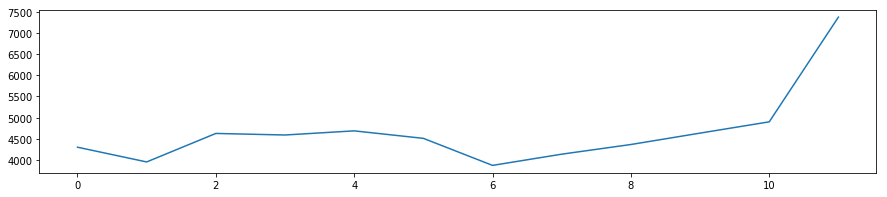

In [10]:
plot_padded_data(last_year, "amount")

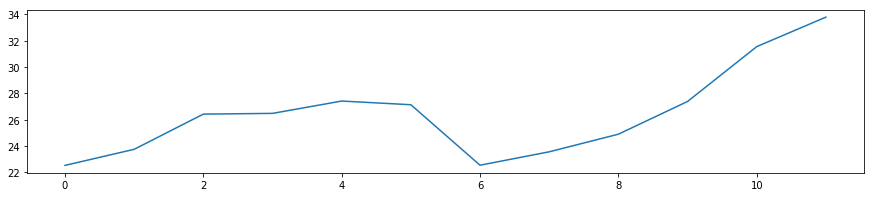

In [11]:
plot_padded_data(last_year, "donations_count")

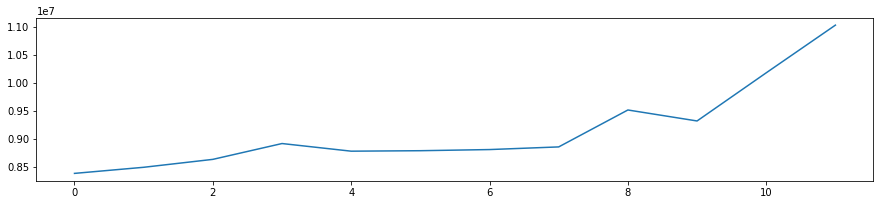

In [12]:
plot_padded_data(last_year, "recurring")

It appears in examining the transaction means (volume and count) that everything drop offs sharply at the end but continues to rise organically building up to it. _The important caveat here is that these are mean values, so this could be skewed by padded 0's and outliers._ I will try altering the data in two ways to verify this result:

1. We will remove all organizations with less than 12 months data so that the data is not skewed by the 0 padding
2. We will normalize the data in order to remove the influence of outliers

## Removing organizations with less than 12 months data

In [13]:
def plot_data(df, col, plot=True):
    data_amount = {}

    for o in last_year.org.unique():
        amount_vals = last_year[last_year['org']==o][col].tolist()
        if (len(amount_vals) == 12):
            data_amount[o] = amount_vals
        
    df_amounts = pd.DataFrame(data_amount.values())
    means = df_amounts.mean()
    if plot:
        means.plot(figsize=(15,3))
    else:
        return means

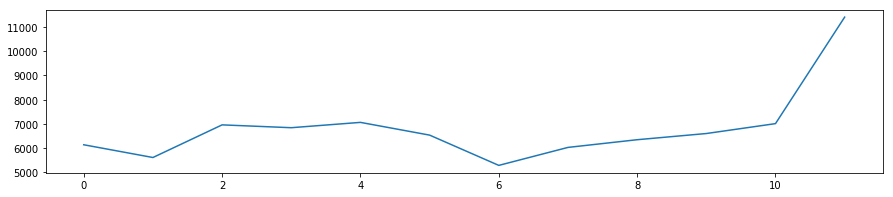

In [14]:
plot_data(last_year, "amount")

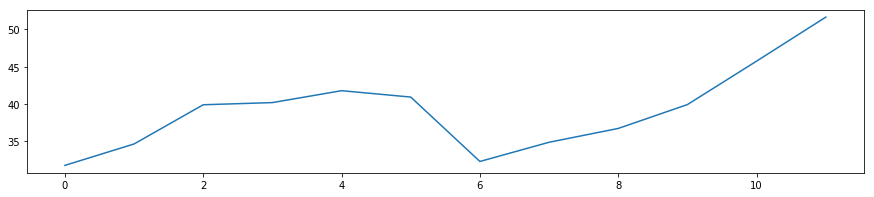

In [15]:
plot_data(last_year, "donations_count")

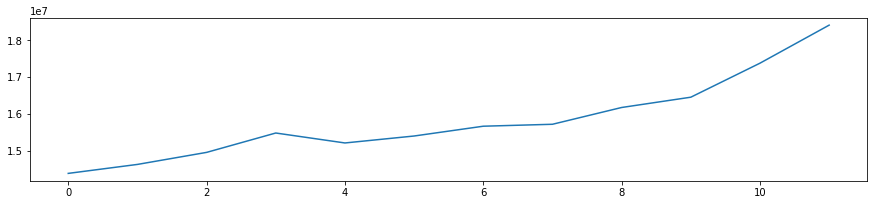

In [16]:
plot_data(last_year, "recurring")

__Examining the data without the 0-padded entries does not meaningfully change the trends.__

## Normalizing the data

In [17]:
def plot_normalized_data(df, col, plot=True):
    data_amount = {}

    for o in last_year.org.unique():
        amount_vals = last_year[last_year['org']==o][col].tolist()
        if (len(amount_vals) == 12):
            data_amount[o] = amount_vals / np.linalg.norm(amount_vals)
        
    df_amounts = pd.DataFrame(data_amount.values())
    means = df_amounts.mean()
    if plot:
        means.plot(figsize=(15,3))
    else:
        return means

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


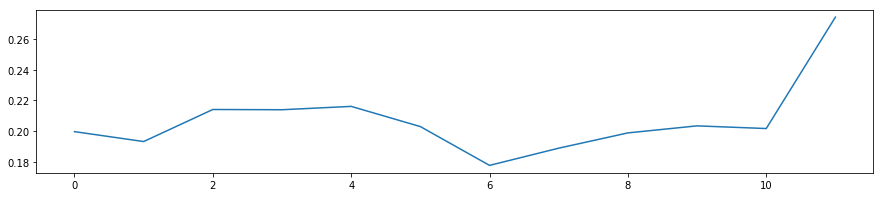

In [18]:
plot_normalized_data(last_year, "amount")

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


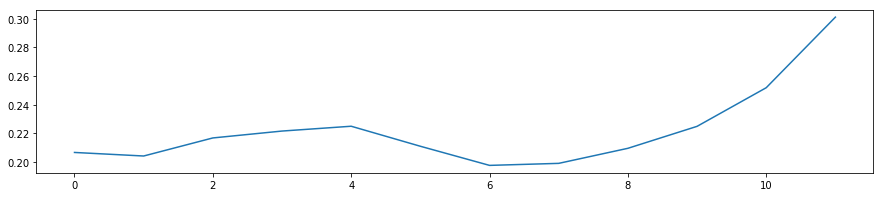

In [19]:
plot_normalized_data(last_year, "donations_count")

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


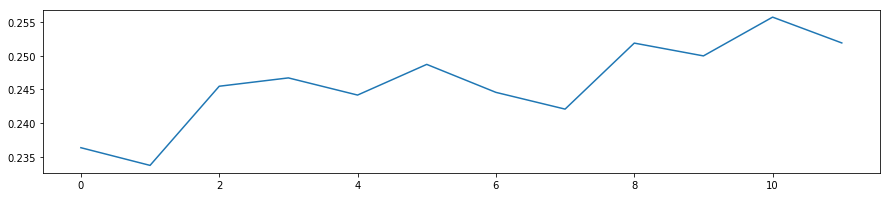

In [20]:
plot_normalized_data(last_year, "recurring")

The normalized data with 0-padded entries removed had nearly identical trends to the others, so __it appears that the transaction data does not contain a meaningful churn notification.__ 

This data does include all forms, so it is highly likely that the views of the data rendered here are largely that of the 2018 processing year for all forms, thus we see the processing rise to the end of the visualized dataset. We need to visualize the __closed__ orgs in isolation in order to verify the lack of indicative trend.

## Isolating closed orgs

In [21]:
ORGANIZATION_IDS = "organizations.csv"

df_orgs = pd.read_csv(ORGANIZATION_IDS)

df_orgs_cols = ["Id", "Date Closed", "Go Live Date"]

df_orgs = df_orgs[df_orgs_cols]
df_orgs["Date Closed"] = pd.to_datetime(df_orgs["Date Closed"])
df_orgs["Go Live Date"] = pd.to_datetime(df_orgs["Go Live Date"])
df_orgs.head()

,Id,Date Closed,Go Live Date
0,441789,NaT,1969-12-31
1,443044,NaT,1969-12-31
2,1045,2011-06-30,2011-03-14
3,442134,NaT,2017-11-06
4,442293,NaT,2018-01-29


In [22]:
null_closed_orgs = len(df_orgs[df_orgs["Date Closed"].isnull()])
len_orgs = len(df_orgs)
null_perc = (float(null_closed_orgs) / float(len_orgs)) * 100
"{:.2f}% orgs not closed of {}".format(null_perc, len_orgs)

'77.21% orgs not closed of 6226'

In [23]:
closed_orgs = df_orgs[~df_orgs["Date Closed"].isnull()]['Id'].tolist()

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


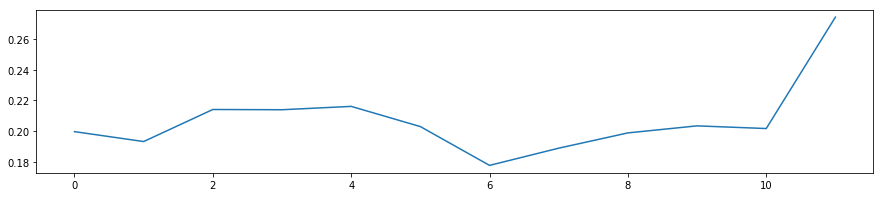

In [24]:
plot_normalized_data(last_year[last_year['org'].isin(closed_orgs)], "amount")

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


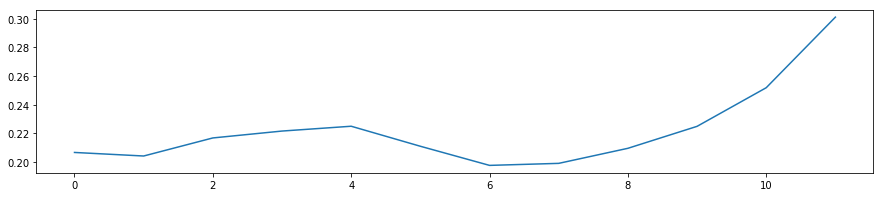

In [25]:
plot_normalized_data(last_year[last_year['org'].isin(closed_orgs)], "donations_count")

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


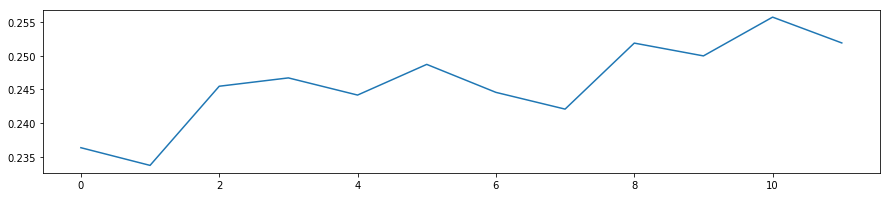

In [26]:
plot_normalized_data(last_year[last_year['org'].isin(closed_orgs)], "recurring")

It appears that isolating orgs with closed dates does not meaningfully alter the processing trend. Transaction activity does not appear to be a leading indicator of churn.

In [27]:
# isolating form IDs mapped to org IDs from transactions
form_orgs_map = trans[["form", "org"]].groupby("form")['org'].first().reset_index()

# Analytics

Here we will examine the characteristics of churning clients from the form analytics data. 

__Hypothesis__: we assume that churning clients will experience a wind down period where in they are either (1) removing or disabling setting from their form or (2) not creating them at the same frequency as before as they are shifting resources to the new platform.

__Data notes__: The analytics data does not contain a usable flag to identify closed accounts. We will identify these by a separate dataset containing organization ID's, status and date closed (_analytics/organizations.csv_).

In [28]:
ANALYTICS_BASE_PATH = "analytic_base.csv"

ANALYTICS_QGIV_PATH = "analytics/analytic_qgiv.csv"
ANALYTICS_P2P_PATH = "analytics/analytic_p2p.csv"

In [29]:
def get_org_id(form_id):
    if len(form_orgs_map[form_orgs_map['form']==form_id]['org']) > 0:
        return form_orgs_map[form_orgs_map['form']==form_id]['org'].iloc[0]
    else:
        return None

df_base = pd.read_csv(ANALYTICS_BASE_PATH)
#df_base['org'] = df_base['entity'].apply(get_org_id)
#df_base.to_csv(ANALYTICS_BASE_PATH)

In [30]:
df_base["date"] = pd.to_datetime(df_base["tm_stamp"])
df_base['form'] = df_base['entity']
drop_cols = ["tm_stamp", "entity", "entityType", "sic", "path", "visits", "ein", "kiosk_trans_vol", "kiosk_trans_count", "givi_trans_count", "givi_trans_vol", "fb_trans_vol", "fb_trans_count"]
df_base.drop(drop_cols, axis=1, inplace=True)
df_base.head()

,Unnamed: 0,don_form_trans_count,don_form_trans_vol,id,ids,mobile_trans_count,mobile_trans_vol,mobile_visits,mobilevt_trans_count,mobilevt_trans_vol,...,product,rec_trans_count,rec_trans_vol,sms_trans_count,sms_trans_vol,vt_trans_count,vt_trans_vol,org,date,form
0,0,0,0.0,47131755,"47131755,47101203,47116475,47147054",0,0.0,0,0,0.0,...,1.0,0,0.0,0,0.0,0,0.0,NaN,2018-06-27,934771
1,1,0,0.0,44787400,"44787400,44772720,44758040,44802081",0,0.0,0,0,0.0,...,1.0,0,0.0,0,0.0,0,0.0,NaN,2018-05-19,934771
2,2,0,0.0,44137209,"44137209,44122731,44151693,44166184",0,0.0,0,0,0.0,...,1.0,0,0.0,0,0.0,0,0.0,NaN,2018-05-08,934771
3,3,0,0.0,45558379,"45558379,45573358,45528482,45543427",0,0.0,0,0,0.0,...,1.0,0,0.0,0,0.0,0,0.0,NaN,2018-06-01,934771
4,4,0,0.0,44860872,"44860872,44816762,44831443,44846146",0,0.0,0,0,0.0,...,1.0,0,0.0,0,0.0,0,0.0,NaN,2018-05-20,934771


In [31]:
null_orgs = len(df_base[df_base['org'].isnull()])
len_entries = len(df_base)
null_perc = (float(null_orgs) / float(len_entries)) * 100
"{:.2f}% null org entries out of {}".format(null_perc, len_entries)

'27.89% null org entries out of 4500045'

In [32]:
# narrow dataset to non-null org entries
df_base_nn = df_base[~df_base['org'].isnull()]

In [33]:
closed_orgs = df_orgs[~df_orgs["Date Closed"].isnull()]['Id'].tolist()
open_orgs = df_orgs[df_orgs["Date Closed"].isnull()]["Id"].tolist()

print("{} closed orgs; {} open orgs".format(len(closed_orgs), len(open_orgs)))

1419 closed orgs; 4807 open orgs


## Settings

Look at the correlation between form settings and closed orgs. Ie, are churned orgs more or less likely to use a given feature than non-churned org's? This will be evaluated by simulation through transaction source counts.

In [41]:
df_base_churned = df_base[df_base.org.isin(closed_orgs)]
df_base_nonchurned = df_base[df_base.org.isin(open_orgs)]

cols_to_check = ["don_form_trans_count", "mobile_trans_count", "mobilevt_trans_count", "one_time_trans_count", "rec_trans_count", "p2p_trans_count", "sms_trans_count", "vt_trans_count"]

In [42]:
df_base_churned[cols_to_check].mean()

don_form_trans_count    0.033373
mobile_trans_count      0.015670
mobilevt_trans_count    0.001526
one_time_trans_count    0.033373
rec_trans_count         0.018466
p2p_trans_count         0.065974
sms_trans_count         0.004268
vt_trans_count          0.014307
dtype: float64

In [43]:
df_base_nonchurned[cols_to_check].mean()

don_form_trans_count    0.127019
mobile_trans_count      0.024052
mobilevt_trans_count    0.003858
one_time_trans_count    0.127019
rec_trans_count         0.081495
p2p_trans_count         0.067345
sms_trans_count         0.003408
vt_trans_count          0.014474
dtype: float64

It appears that for most transaction sources, non-churned org's are meaningfully higher. Specifically we can see that __one time and recurring transaction counts for non-churned org's are about 4 times greater than the churned org's__. The notable exceptions of P2P, SMS, and VT. A few theories here might be that

1. SMS and VT are specific application product categories, so the client may have signed up for this specific feature with no intention of broad implementation
2. P2P is a seasonal product and the client may exhibit low platform loyalty year over year
3. P2P, SMS and VT are ephemeral/circumstantial with low investment applications so clients using these without year round implementation may find it much easier to transition platforms

Things to explore:

1. Churn distribution for org's using only these products (P2P, SMS, VT)
2. Churn distribution for org's using these products (P2P, SMS, VT) as well as year round